In [1]:
%matplotlib inline
import pandas as pd
from patsy import dmatrices
import numpy as np
import statsmodels.api as sm
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
from statsmodels.compat import lzip
from statsmodels.graphics.api import abline_plot
from statsmodels.genmod.generalized_linear_model import GLM
pd.set_option('display.max_rows', None)

### Poisson Process- 1

Our
goal is to investigate the suitability of both homogeneous and in-homogeneous
Poisson processes to model the claim arrivals. We first visualize the dataset and
investigate the descriptive statistics of the arrival and inter-arrival times for the
whole period. We initially assume that the claim arrival process follows a ho-
mogeneous Poisson process and subsequently calibrate the intensity parameter
to the data.

**the main difference between a homogenous vs. non-homogenous/in-homogenoeous Poisson process is that a homogenous Poisson process has a constant rate parameter λ while a non-homogenous Poisson process can have a variable rater parameter λ(t) that is a function of time.**

In [2]:
df = pd.read_csv('C:/Users/ramya/Desktop/Santa_Clara_University/Projects/GLM/Actuarial_Statistics-master/1. Claim Arrivals - Poisson/data/DanishData.csv')

df["Date"] = df["Date"].apply(lambda x : x.split(" ")[0])

df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df = df.dropna(subset=['Date'])

df.head()

,Date,Loss-in-DKM
0,1980-01-03,1.683748
1,1980-01-04,2.093704
2,1980-01-05,1.732581
3,1980-01-07,1.779754
4,1980-01-07,4.612006


The Danish fire insurance set contains 2167 claim counts. A visualization of the
arrival times and the corresponding number of cumulative arrivals up to that
time point are shown on the top graph, in figure 1. The x-axis represents the
number of days passed since January 1, 1980. The y-axis represents the proportion
of claims that have been received up to this date. The bottom graph (Figure 2)
illustrates the frequency distribution of the inter-arrival times.

In [3]:
df["Num_days"]= (df["Date"]-pd.to_datetime("1980-01-01")).dt.days

df.head()

,Date,Loss-in-DKM,Num_days
0,1980-01-03,1.683748,2
1,1980-01-04,2.093704,3
2,1980-01-05,1.732581,4
3,1980-01-07,1.779754,6
4,1980-01-07,4.612006,6


Text(0.5, 1.0, 'Figure 1')

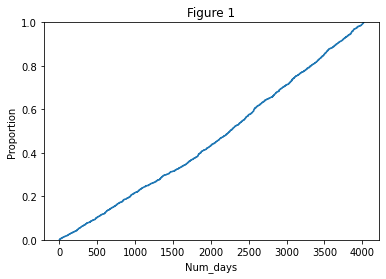

In [4]:
sns.ecdfplot(data=df, x="Num_days").set_title('Figure 1')
# An ECDF represents the proportion or count of observations falling below each unique value in a dataset.
#Compared to a histogram or density plot, it has the advantage that each observation is visualized directly, 
#meaning that there are no binning or smoothing parameters that need to be adjusted.

Text(0.5, 1.0, 'Figure 2')

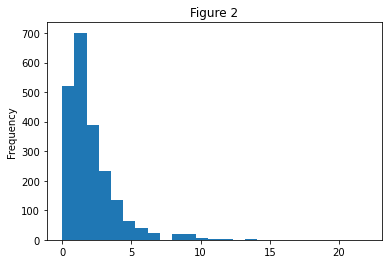

In [5]:
df["Inter_arrival_times"] = ((df["Date"] - df["Date"].shift(1)).dt.days)
df["Inter_arrival_times"].fillna(2,inplace=True)
((df["Date"] - df["Date"].shift(1)).dt.days).plot(kind="hist",bins=25).set_title('Figure 2')
# Frequency versus Claim Inter arrival time in days

<AxesSubplot:xlabel='Year', ylabel='count'>

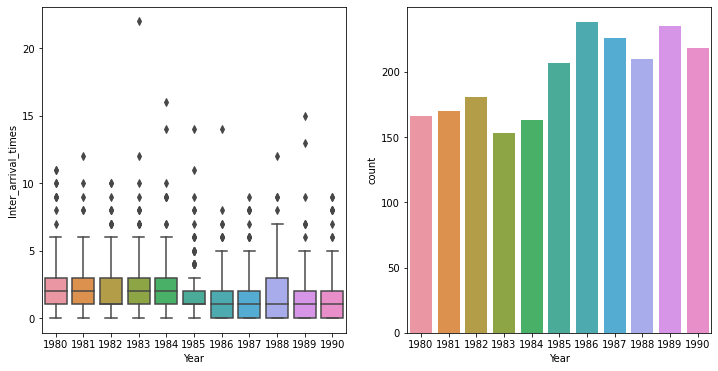

In [6]:
df["Year"]= df["Date"].dt.year

plt.figure(figsize=(12,6))
plt.subplot(121)
sns.boxplot(x="Year", y="Inter_arrival_times", data=df)

plt.subplot(122)
sns.countplot(x="Year", data=df)

In [7]:
df2=df.groupby("Date").agg({"Inter_arrival_times":"sum","Date":"count","Year":"max"}).\
rename(columns={"Date":"count"})

In [8]:
# ref - https://towardsdatascience.com/understanding-maximum-likelihood-estimation-fa495a03017a

In [9]:
# Here count~1 means that the model only depends on count distribution only
# Why are we using offset? https://stats.stackexchange.com/questions/11182/when-to-use-an-offset-in-a-poisson-regression

smf.glm(formula = "count~1", family=sm.families.Poisson(),data=df2,offset=np.log(df2["Inter_arrival_times"])).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  count   No. Observations:                 1645
Model:                            GLM   Df Residuals:                     1644
Model Family:                 Poisson   Df Model:                            0
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2560.0
Date:                Sun, 25 Apr 2021   Deviance:                       1533.6
Time:                        15:56:10   Pearson chi2:                 2.05e+03
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.6172      0.021    -28.731      0.000      -0.659      -0.575
==============================================================================
"""

In [10]:
lambda_ = np.exp(-0.6172)
lambda_

0.5394527927316728

Thus we calibrated the data for by homogenoeous data assumption. Now let us dig deeper.
The figure illustrates that the function is not stationary: The
estimates of the the mean inter-arrival times move downwards over time which
provides further evidence that the empirical data is indeed of in-homogeneous
nature.


<AxesSubplot:xlabel='Date'>

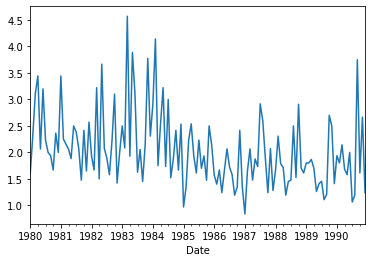

In [11]:
df.set_index("Date",inplace=True)

(df['Inter_arrival_times'].resample('M').mean()).plot()

In the previous subsection we concluded that the homogeneity assumption for
the complete time period was not met(the below figure once shows the decreasing trend in arrival time) . However, a homogeneous model assumption might be suitable for the arrival process during shorter time periods such as
one year.\
In this section we utilize an in-homogeneous Poisson process with continuous
mean value function to model the arrival process. In the last section we
concluded that the claim arrival process for the data could be consid-
ered homogeneous during shorter yearly intervals. Hence, we can utilize the
estimated yearly intensity rates to estimate mu(t) as a
piecewise linear function with altering slopes during different years.

<AxesSubplot:xlabel='Date'>

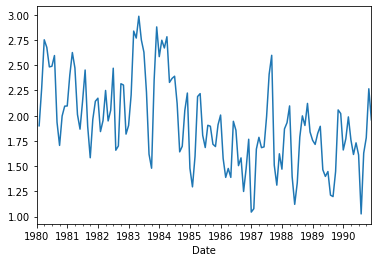

In [12]:
df["rolling_mean_inter_arrival_time"]= df['Inter_arrival_times'].rolling(30).mean()
(df['rolling_mean_inter_arrival_time'].resample('M').mean()).plot()

Now let us plot the same plot for each year

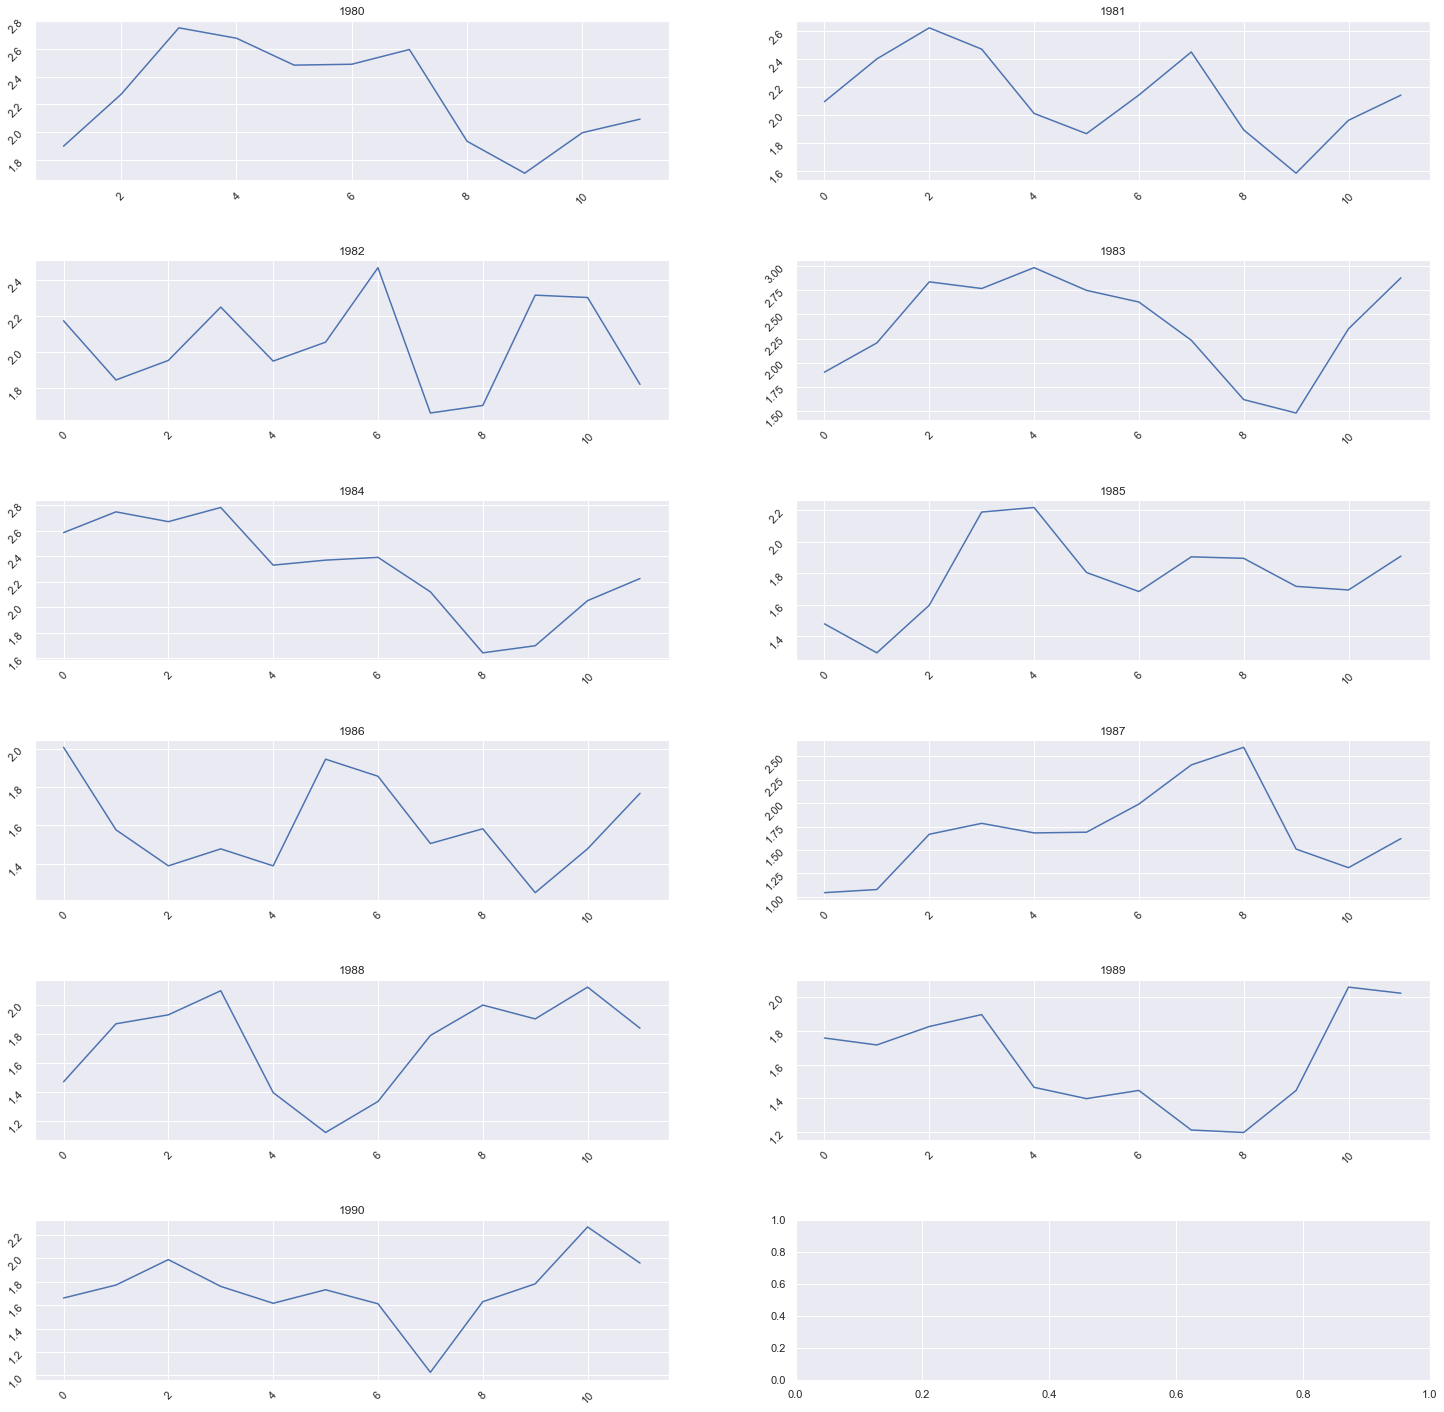

In [13]:
sns.set(font_scale=1) 
fig, axes = plt.subplots(6, 2, figsize=(25, 25))
axes = axes.flatten()

for i,j in zip(df.Year.unique(),axes):
    
    df2 =pd.DataFrame(df[df["Year"]==i]['rolling_mean_inter_arrival_time'].resample('M').mean()).reset_index()

    sns.lineplot(data=df2,ax=j)
    j.legend_.remove()
    j.set_title(i)
    j.tick_params(labelrotation=45)
plt.subplots_adjust(hspace = 0.5)


### Poisson Regression -2 


#ref -https://towardsdatascience.com/an-illustrated-guide-to-the-poisson-regression-model-50cccba15958

**What is count based data?**
Count based data contains events that occur at a certain rate. The rate of occurrence may change over time or from one observation to next. Here are some examples of count based data:

- Number of vehicles crossing an intersection per hour,
- Number of people visiting a doctor’s office per month,
- Number of earth-like planets spotted per month.

A data set of counts has the following characteristics:
- Whole number data: The data consists of non-negative integers: [0… ∞] Regression techniques such as Ordinary Least Squares Regression may not be appropriate for modeling such data as OLSR works best on real numbers such as -656.0, -0.00000345, 13786.1 etc.
- Skewed Distribution: The data may contain a large number of data points for just a few values, thereby making the frequency distribution quite skewed. See for example above histogram.
- Sparsity: The data may reflect the occurrence of a rare event such as a gamma ray burst, thereby making the data sparse.
- Rate of occurrence: For the sake of creating a model, it can be assumed that there is a certain rate of occurrence of events λ that drives the generation of such data. The event rate may drift over time.

Regression models for counts\
The Poisson regression model and the Negative Binomial regression model are two popular techniques for developing regression models for counts. Other possibilities are Ordered Logit, Ordered Probit and Nonlinear Least Squares models.
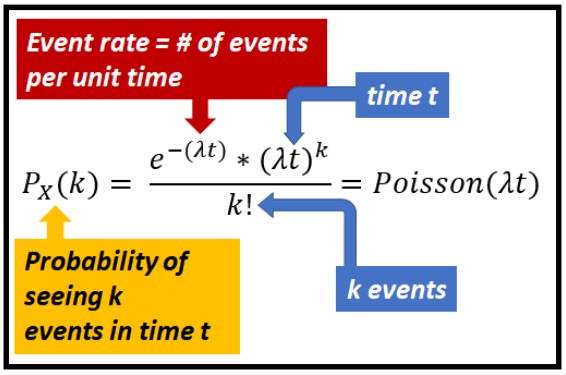

The expected value (mean) for a Poisson distribution is λ. Thus in the absence of other information, one should expect to see λ events in any unit time interval such as 1 hour, 1 day, etc. For any interval t, one would expect to see λt events.

In [14]:
df = pd.read_csv("nyc_bb_bicyclist_counts.csv",header=0, infer_datetime_format=True, parse_dates=[0], index_col=[0])
df.head()

,HIGH_T,LOW_T,PRECIP,BB_COUNT
Date,,,,
2017-04-01,46.0,37.0,0.00,606
2017-04-02,62.1,41.0,0.00,2021
2017-04-03,63.0,50.0,0.03,2470
2017-04-04,51.1,46.0,1.18,723
2017-04-05,63.0,46.0,0.00,2807


In [15]:
#Add a few derived regression variables.
ds = df.index.to_series()
df['MONTH'] = ds.dt.month
df['DAY_OF_WEEK'] = ds.dt.dayofweek
df['DAY'] = ds.dt.day
df.head()

,HIGH_T,LOW_T,PRECIP,BB_COUNT,MONTH,DAY_OF_WEEK,DAY
Date,,,,,,,
2017-04-01,46.0,37.0,0.00,606,4,5,1
2017-04-02,62.1,41.0,0.00,2021,4,6,2
2017-04-03,63.0,50.0,0.03,2470,4,0,3
2017-04-04,51.1,46.0,1.18,723,4,1,4
2017-04-05,63.0,46.0,0.00,2807,4,2,5


In [16]:
#Create the training and testing data sets.
mask = np.random.rand(len(df)) < 0.8
df_train = df[mask]
df_test = df[~mask]
print('Training data set length='+str(len(df_train)))
print('Testing data set length='+str(len(df_test)))

Training data set length=174
Testing data set length=40


The fitting of y(counts) to X happens by fixing the values of a vector of regression coefficients β.
In a Poisson Regression model, the event counts y are assumed to be Poisson distributed, which means the probability of observing y is a function of the event rate vector λ.
The job of the Poisson Regression model is to fit the observed counts y to the regression matrix X via a link-function that expresses the rate vector λ as a function of, 1) the regression coefficients β and 2) the regression matrix X.
The following figure illustrates the structure of the Poisson regression model.

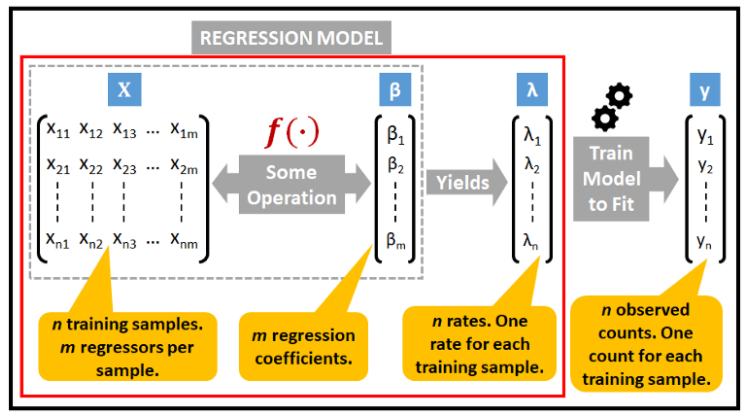

In [17]:
expr = """BB_COUNT ~ DAY  + DAY_OF_WEEK + MONTH + HIGH_T + LOW_T + PRECIP"""
y_train, X_train = dmatrices(expr, df_train, return_type='dataframe')
y_test, X_test = dmatrices(expr, df_test, return_type='dataframe')

In [18]:
#Using the statsmodels GLM class, train the Poisson regression model on the training data set.
poisson_training_results = sm.GLM(y_train, X_train, family=sm.families.Poisson()).fit()

In [19]:
#Print the training summary.
print(poisson_training_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:               BB_COUNT   No. Observations:                  174
Model:                            GLM   Df Residuals:                      167
Model Family:                 Poisson   Df Model:                            6
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -11761.
Date:                Sun, 25 Apr 2021   Deviance:                       21840.
Time:                        15:56:14   Pearson chi2:                 2.13e+04
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       7.0303      0.012    573.998      

In [20]:
#Make some predictions on the test data set.
poisson_predictions = poisson_training_results.get_prediction(X_test)
#.summary_frame() returns a pandas DataFrame
predictions_summary_frame = poisson_predictions.summary_frame()
print(predictions_summary_frame)


                   mean    mean_se  mean_ci_lower  mean_ci_upper
Date                                                            
2017-04-06  1197.080666   7.577873    1182.320065    1212.025545
2017-04-11  3129.475640  11.275981    3107.452978    3151.654378
2017-04-26  1722.196827   7.537356    1707.487061    1737.033315
2017-05-04  2431.440742   8.188451    2415.444524    2447.542895
2017-05-08  2458.986056  10.416633    2438.654352    2479.487271
2017-05-11  2285.653972   7.152406    2271.678416    2299.715507
2017-05-18  3355.574858  11.918499    3332.296151    3379.016185
2017-05-28  2516.879132   9.008118    2499.285326    2534.596790
2017-06-04  2099.980279   8.428415    2083.525694    2116.564814
2017-06-07  2636.314330   7.021501    2622.588298    2650.112201
2017-06-10  2988.951806   8.893226    2971.572128    3006.433131
2017-06-14  2599.315574   7.482452    2584.691532    2614.022359
2017-06-15  2628.172117   6.282768    2615.886921    2640.515010
2017-06-21  2923.892508  

In [21]:
predicted_counts=predictions_summary_frame['mean']
actual_counts = y_test['BB_COUNT']


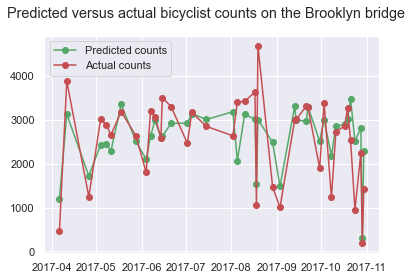

In [22]:
#Mlot the predicted counts versus the actual counts for the test data.
fig = plt.figure()
fig.suptitle('Predicted versus actual bicyclist counts on the Brooklyn bridge')
predicted, = plt.plot(X_test.index, predicted_counts, 'go-', label='Predicted counts')
actual, = plt.plot(X_test.index, actual_counts, 'ro-', label='Actual counts')
plt.legend(handles=[predicted, actual])
plt.show()

<Figure size 432x288 with 0 Axes>

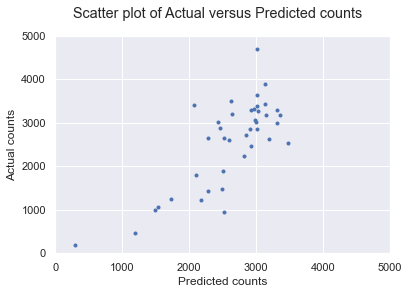

In [26]:
#Show scatter plot of Actual versus Predicted counts
plt.clf()
fig = plt.figure()
fig.suptitle('Scatter plot of Actual versus Predicted counts')
plt.scatter(x=predicted_counts, y=actual_counts, marker='.')
plt.xlabel('Predicted counts')
plt.ylabel('Actual counts')
plt.xlim([0, 5000])
plt.ylim([0, 5000])

plt.show()